<a href="https://colab.research.google.com/github/NassimZahri/Data_Mining/blob/main/07_mini_projet_end_to_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07 — Mini-Projet End-to-End
Objectif : réaliser un flux complet depuis le chargement jusqu'à un petit modèle prédictif.

**Tâche :** prédire `quantity` à partir de features simples (prix, promo, mois, jour_semaine, catégorie).

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Load directly from GitHub raw URLs
base_url = 'https://raw.githubusercontent.com/NassimZahri/Data_Mining/main/data/'

# DATA_DIR = Path('data')
ventes = pd.read_csv(base_url + 'ventes.csv', parse_dates=['date'])
produits = pd.read_csv(base_url + 'produits.csv')
df = ventes.merge(produits[['product_id','category']], on='product_id', how='left')

# Features
df['month'] = df['date'].dt.month
df['dow'] = df['date'].dt.dayofweek

# Nettoyage minimal
df['price'] = df['price'].fillna(df['price'].median())
df['quantity'] = df['quantity'].fillna(0).clip(lower=0)

X = df[['price','promo','month','dow','category']]
y = df['quantity']

num_cols = ['price','promo','month','dow']
cat_cols = ['category']

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

model = Pipeline([
    ('prep', preprocess),
    ('linreg', LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train, y_train)
pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
print('MAE =', round(mae,3), '| R2 =', round(r2,3))


MAE = 3.044 | R2 = -0.008


## 1. Importance (approche simple via coefficients)

In [5]:
# Récupération des coefficients de la régression linéaire
lin = model.named_steps['linreg']
prep = model.named_steps['prep']

# Noms des features après One-Hot
num_names = num_cols
cat_names = list(prep.named_transformers_['cat'].get_feature_names_out(cat_cols))
feat_names = num_names + cat_names

coefs = pd.Series(lin.coef_, index=feat_names).sort_values(key=abs, ascending=False)
coefs.head(10)


,0
category_Technologie,-0.430481
category_Electroménager,0.427079
category_Hygiène,-0.318787
promo,0.211108
category_Textile,0.186865
category_Bricolage,0.095165
price,0.069567
dow,-0.044387
category_Alimentaire,0.040159
month,0.017497


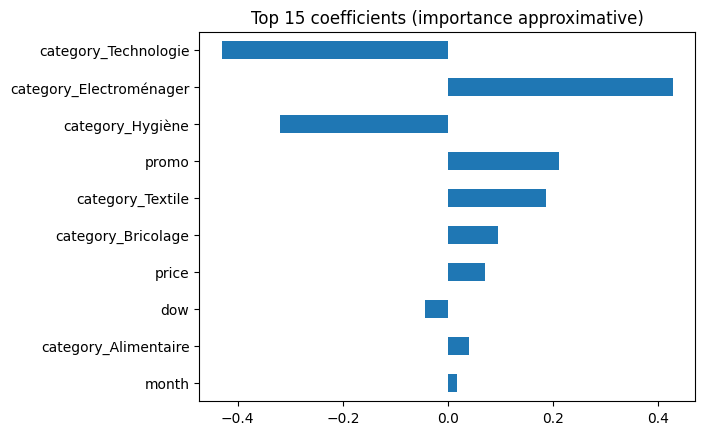

In [6]:
plt.figure()
coefs.head(15).plot(kind='barh')
plt.title('Top 15 coefficients (importance approximative)')
plt.gca().invert_yaxis()
plt.show()


## 2. EXERCICE
- Remplacez `LinearRegression` par `RandomForestRegressor` et comparez MAE/R2.
- Ajoutez une feature `price_per_unit = total / max(quantity,1)` et observez l'impact.
- Créez un graphique des erreurs (`y_test - pred`).

RandomForest - MAE: 2.981 | R2: 0.035
Comparaison avec LinearRegression (MAE: 3.044, R2: -0.008)


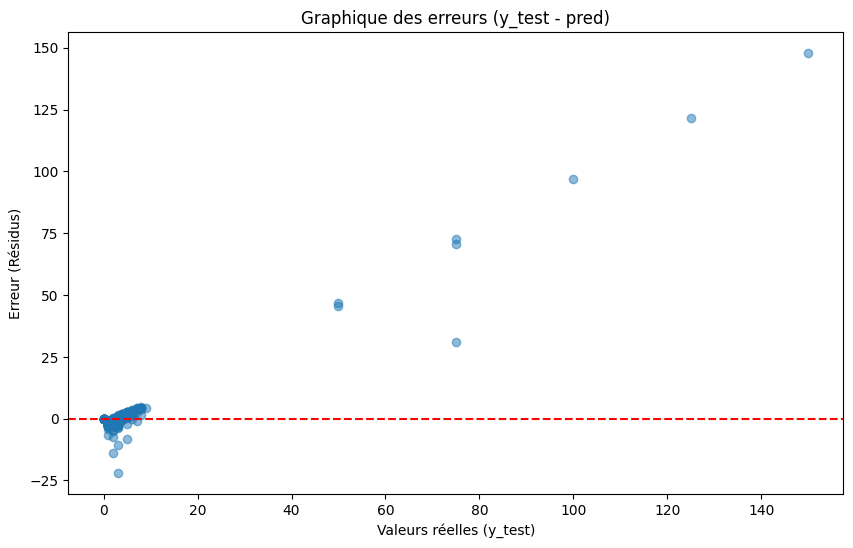

In [10]:
from sklearn.ensemble import RandomForestRegressor

# 1. Ajout de la feature price_per_unit
# On utilise np.maximum pour éviter la division par zéro
df['price_per_unit'] = df['total'] / np.maximum(df['quantity'], 1)

# 2. Mise à jour des features
X = df[['price', 'promo', 'month', 'dow', 'category', 'price_per_unit']]
y = df['quantity']

num_cols = ['price', 'promo', 'month', 'dow', 'price_per_unit']
cat_cols = ['category']

# 3. Nouveau pipeline avec RandomForestRegressor
preprocess_rf = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

model_rf = Pipeline([
    ('prep', preprocess_rf),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=0))
])

# 4. Entraînement et évaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, pred_rf)
r2_rf = r2_score(y_test, pred_rf)

print(f"RandomForest - MAE: {mae_rf:.3f} | R2: {r2_rf:.3f}")
print(f"Comparaison avec LinearRegression (MAE: {mae:.3f}, R2: {r2:.3f})")

# 5. Graphique des erreurs
errors = y_test - pred_rf
plt.figure(figsize=(10, 6))
plt.scatter(y_test, errors, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Graphique des erreurs (y_test - pred)')
plt.xlabel('Valeurs réelles (y_test)')
plt.ylabel('Erreur (Résidus)')
plt.show()